In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from model import DenseNet121, CLASS_NAMES
# encoding: utf-8

"""
Fixed Evaluation Code for CheXNet
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import densenet121
from sklearn.metrics import roc_auc_score
import sys
sys.path.append('path_to_directory_containing_read_data')  # Update this path
from read_data import ChestXrayDataSet
from tqdm import tqdm  # For progress tracking
# Importing the model and class names from model.py


In [2]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hooks to save activations and gradients
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
    # Compute the weights
        weights = self.gradients.mean(dim=[0, 2, 3]).to(self.activation.device)  # Ensure weights are on the same device as activation
        activation = self.activation.squeeze(0).detach()

    # Initialize the heatmap on the correct device
        heatmap = torch.zeros(activation.shape[1:], device=activation.device)

    # Compute the weighted sum of activations
        for i, w in enumerate(weights):
            heatmap += w * activation[i]

    # Apply ReLU to remove negative values
        heatmap = torch.clamp(heatmap, min=0)
        return heatmap.cpu().numpy()  # Move to CPU for visualization

In [3]:
 # Path to the pre-trained model checkpoint
N_CLASSES = len(CLASS_NAMES)  # Number of classes

CKPT_PATH = "arnoweng-model.pth.tar"  # Path to the model checkpoint
# Initialize the model
model = DenseNet121(N_CLASSES).cuda()

# Load the checkpoint
checkpoint = torch.load(CKPT_PATH)

# Adjust state_dict to fix keys
state_dict = checkpoint["state_dict"]
new_state_dict = {}
for k, v in state_dict.items():
    # Remove 'module.' prefix if present
    new_key = k.replace("module.", "")
    # Replace 'norm.1' with 'norm1', 'conv.1' with 'conv1', etc.
    new_key = new_key.replace(".1", "1").replace(".2", "2").replace(".3", "3")
    new_state_dict[new_key] = v

# Load the adjusted state_dict
model.load_state_dict(new_state_dict)

# Set model to evaluation mode
model.eval()

print("Model loaded successfully with adjusted state_dict!")


C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\zafer\AppData\Local\Temp\ipykernel_6912\368776349.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses 

Model loaded successfully with adjusted state_dict!


In [4]:
# Identify the target layer for Grad-CAM
target_layer = model.densenet121.features[-1]  # Last convolutional layer of DenseNet121
grad_cam = GradCAM(model, target_layer)


In [5]:
# Best thresholds
best_thresholds = [
    0.66,  # Atelectasis
    0.71,  # Cardiomegaly
    0.66,  # Effusion
    0.63,  # Infiltration
    0.70,  # Mass
    0.69,  # Nodule
    0.69,  # Pneumonia
    0.69,  # Pneumothorax
    0.67,  # Consolidation
    0.70,  # Edema
    0.71,  # Emphysema
    0.72,  # Fibrosis
    0.69,  # Pleural_Thickening
    0.71   # Hernia
]

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model's input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

In [7]:
def process_image(image_input):
    """
    Processes the image for model input.
    Args:
        image_input: Path to the image file (string) or a PIL Image object.
    Returns:
        input_tensor: Processed tensor ready for the model.
        image: Original PIL Image object for visualization.
    """
    if isinstance(image_input, str):  # If input is a file path
        image = Image.open(image_input).convert('RGB')  # Ensure 3-channel RGB
    elif isinstance(image_input, Image.Image):  # If input is already a PIL Image
        image = image_input
    else:
        raise ValueError("Unsupported image input type. Provide a file path or PIL Image.")

    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return input_tensor, image

# Predict diseases from the image
def predict_diseases(model, input_tensor):
    device = next(model.parameters()).device  # Ensure model device (CPU or GPU)
    input_tensor = input_tensor.to(device)  # Move input to the same device as the model
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.sigmoid(logits).squeeze().cpu().numpy()
    return probabilities


# Display predictions
def display_predictions(image_path, probabilities):
    # Filter predictions based on thresholds
    detected_diseases = [
        f"{CLASS_NAMES[i]} ({probabilities[i]:.2%})"
        for i in range(len(CLASS_NAMES))
        if probabilities[i] > best_thresholds[i]
    ]
    detected_text = "\n".join(detected_diseases) if detected_diseases else "No diseases detected."

    print(f"\nUploaded Image: {os.path.basename(image_path)}")
    print(f"Predictions:\n{detected_text}")


In [8]:
def grad_cam_on_predictions(model, input_tensor, original_image, class_names, thresholds):
    """
    Generate Grad-CAM visualizations for diseases predicted by the model and plot prediction scores with thresholds.
    Args:
        model: The trained model.
        input_tensor: The input tensor for the image.
        original_image: The original uploaded image (PIL format).
        class_names: List of class names.
        thresholds: List of thresholds for each class.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image

    # Ensure input tensor is on the same device as the model
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    # Get raw logits and predictions
    logits = model(input_tensor)  # Raw output from the model
    probabilities = torch.sigmoid(logits).detach().cpu().numpy().flatten()  # Sigmoid for multi-label probabilities

    # Filter predictions based on thresholds
    predicted_indices = [i for i in range(len(class_names)) if probabilities[i] > thresholds[i]]
    predicted_scores = [probabilities[i] for i in predicted_indices]
    predicted_classes = [class_names[i] for i in predicted_indices]

    # Grad-CAM visualization
    if predicted_classes:
        # Create subplots for the original image and Grad-CAM overlays
        fig, axes = plt.subplots(1, len(predicted_classes) + 1, figsize=(6 * (len(predicted_classes) + 1), 6))

        # Plot the original image in the first column
        axes[0].imshow(original_image)
        axes[0].set_title("Original Image", fontsize=14)
        axes[0].axis("off")

        # Grad-CAM overlays for each predicted disease
        for idx, (disease, score) in enumerate(zip(predicted_classes, predicted_scores)):
            target_class = class_names.index(disease)

            # Generate Grad-CAM heatmap for the specific target class
            model.zero_grad()  # Clear existing gradients
            logits[0, target_class].backward(retain_graph=True)  # Retain the computational graph
            heatmap = grad_cam.generate_heatmap(target_class)  # Assuming grad_cam is initialized
            heatmap = np.maximum(heatmap, 0)
            heatmap /= heatmap.max()

            # Resize and blend heatmap with the original image
            heatmap_resized = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(original_image.size, Image.BICUBIC)
            heatmap_array = np.array(heatmap_resized)
            heatmap_overlay = np.array(original_image).astype(np.float32)
            heatmap_overlay = (
                heatmap_overlay * 0.6 + plt.cm.jet(heatmap_array / 255.0)[:, :, :3] * 255 * 0.4
            ).astype(np.uint8)

            # Plot Grad-CAM overlay with confidence percentage
            axes[idx + 1].imshow(heatmap_overlay)
            axes[idx + 1].set_title(f"{disease}\nConfidence: {score:.2%}")
            axes[idx + 1].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("No predictions above thresholds for Grad-CAM visualization.")

    # Bar Chart for All Predictions
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(
        class_names, 
        probabilities, 
        color=['green' if probabilities[i] > thresholds[i] else 'red' for i in range(len(class_names))]
    )

    # Add threshold lines
    for i, threshold in enumerate(thresholds):
        ax.plot(
            [i - 0.4, i + 0.4],  # X-range for each threshold line
            [threshold, threshold], 
            color='blue', 
            linestyle='--', 
            linewidth=1,
            label=f'{class_names[i]} Threshold' if i == 0 else None  # Add label only once for the legend
        )

    ax.set_title("Disease Prediction Confidence Scores with Thresholds", fontsize=16)
    ax.set_xlabel("Diseases", fontsize=14)
    ax.set_ylabel("Confidence Score", fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    plt.legend(["Thresholds", "Predictions"], loc="upper right")
    plt.tight_layout()
    plt.show()


In [9]:
import requests
from io import BytesIO
from PIL import Image
import os

def download_image_from_url(image_url):
    """
    Downloads an image from the given URL and returns it as a PIL Image object.
    """
    try:
        # Add headers to mimic a browser request
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
            "Referer": image_url  # Sometimes adding the referer helps
        }
        response = requests.get(image_url, headers=headers, stream=True)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx, 5xx)
        
        # Open the image
        return Image.open(BytesIO(response.content)).convert("RGB")
    except requests.exceptions.HTTPError as e:
        print(f"HTTP Error: {e}")
    except requests.exceptions.ConnectionError as e:
        print(f"Connection Error: {e}")
    except Exception as e:
        print(f"Error downloading the image: {e}")
    return None

def process_folder(folder_path):
    """
    Processes all images in the given folder and returns their tensors and original images.
    """
    input_tensors = []
    original_images = []
    file_paths = []
    
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
            try:
                image = Image.open(file_path).convert("RGB")
                input_tensor, original_image = process_image(image)
                input_tensors.append(input_tensor)
                original_images.append(original_image)
                file_paths.append(file_path)
            except Exception as e:
                print(f"Error processing file '{file_name}': {e}")
        else:
            print(f"Skipping non-image file '{file_name}'.")
    
    return input_tensors, original_images, file_paths

import os
from collections import defaultdict

from tqdm import tqdm
import os
from collections import defaultdict

def count_diseases_with_progress(model, input_tensors, class_names, thresholds):
    """
    Counts the number of images with each disease detected and displays a progress bar.
    """
    from tqdm import tqdm
    from collections import defaultdict
    import torch

    disease_counts = defaultdict(int)

    print("Processing images...")
    for tensor in tqdm(input_tensors, desc="Predicting diseases", unit="image"):
        # Ensure input tensor is on the same device as the model
        device = next(model.parameters()).device
        tensor = tensor.to(device)

        # Check tensor dimensions and adjust if needed
        if len(tensor.shape) == 3:  # Single image without batch dimension
            tensor = tensor.unsqueeze(0)  # Add batch dimension
        elif len(tensor.shape) == 5:  # Incorrect extra dimension
            tensor = tensor.squeeze(0)  # Remove unnecessary dimension

        # Get raw logits and predictions
        logits = model(tensor)  # Pass the adjusted tensor to the model
        probabilities = torch.sigmoid(logits).cpu().detach().numpy().flatten()

        # Increment counts for each disease above the threshold
        for idx, prob in enumerate(probabilities):
            if prob > thresholds[idx]:
                disease_counts[class_names[idx]] += 1

    return disease_counts


def main(model):
    # Prompt user for folder path
    folder_path = input("Enter the path to the folder containing images: ")

    if os.path.isdir(folder_path):
        # Handle folder of images
        input_tensors, original_images, file_paths = process_folder(folder_path)

        
        # Count diseases with progress bar
        disease_counts = count_diseases_with_progress(model, input_tensors, CLASS_NAMES, best_thresholds)

        # Display results
        print("\nDisease Detection Summary:")
        for disease, count in disease_counts.items():
            print(f"{disease}: {count}")

    else:
        print(f"Error: The folder '{folder_path}' does not exist.")



In [12]:
input_tensors, original_images = main(model)  # Run main and get tensors and images
if input_tensors is not None and original_images is not None:
    print("\nCounting diseases detected in the images...")
    
    
    # Count diseases
    disease_counts = count_diseases_with_progress(model, input_tensors, CLASS_NAMES, best_thresholds)

    # Display the results
    print("\nDisease Detection Summary:")
    for disease, count in disease_counts.items():
        print(f"{disease}: {count}")


Processing images...


Predicting diseases: 100%|██████████| 4215/4215 [01:48<00:00, 38.67image/s]


Disease Detection Summary:
Atelectasis: 2527
Hernia: 112
Cardiomegaly: 57
Effusion: 544
Infiltration: 828
Consolidation: 458
Edema: 34
Nodule: 54
Pleural_Thickening: 92
Emphysema: 119
Pneumothorax: 279
Mass: 88
Pneumonia: 40
Fibrosis: 10


TypeError: cannot unpack non-iterable NoneType object


Predicting probabilities...


Processing images:   0%|          | 0/3955 [00:00<?, ?image/s]C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Processing images: 100%|██████████| 3955/3955 [01:44<00:00, 37.88image/s]


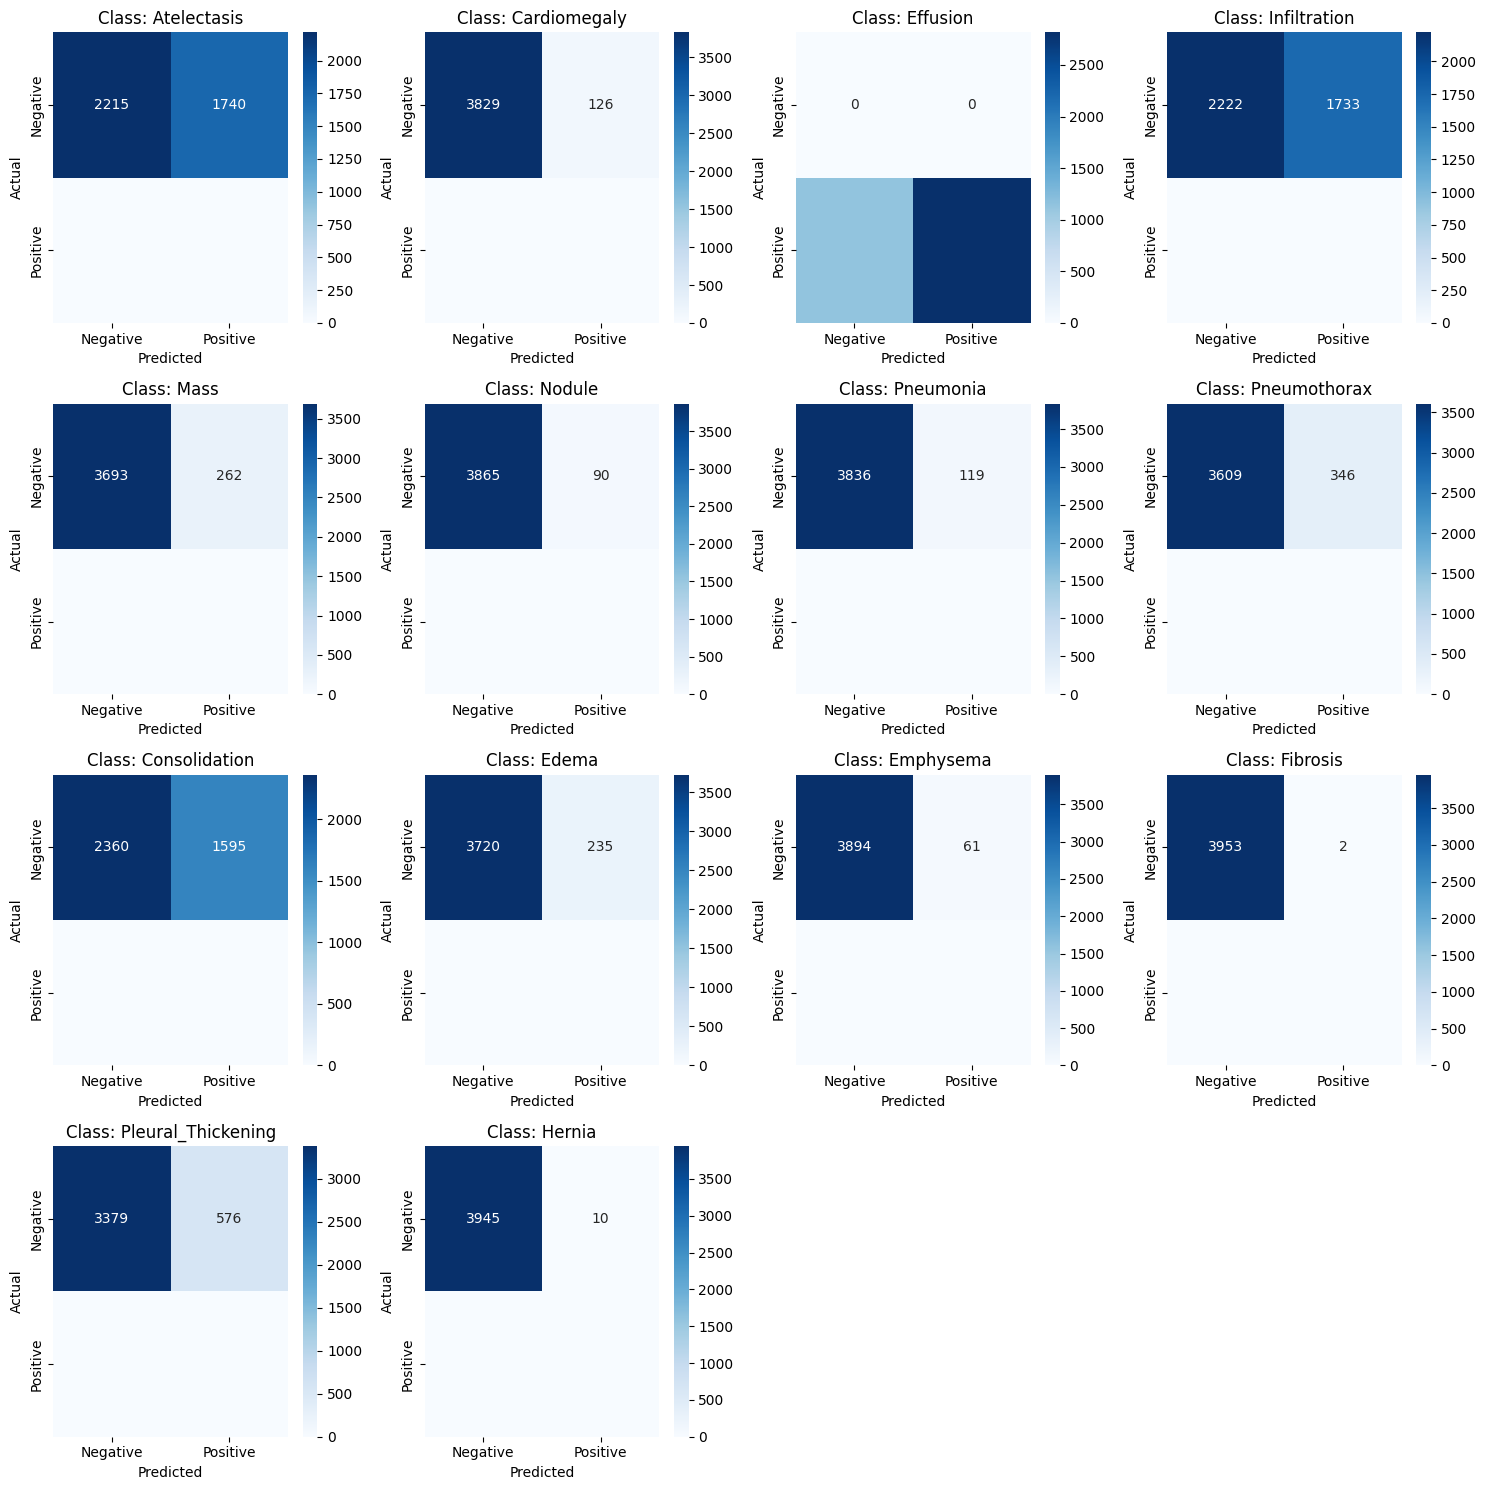

In [18]:
import os
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def generate_confusion_matrix(probabilities, ground_truth, thresholds):
    """
    Generates a confusion matrix for multi-label predictions.
    
    Parameters:
        probabilities: np.ndarray
            Model-predicted probabilities (shape: [num_samples, num_classes]).
        ground_truth: np.ndarray
            Ground truth binary labels (shape: [num_classes]).
        thresholds: list or np.ndarray
            Thresholds for each class (length: num_classes).
    
    Returns:
        confusion_matrices: np.ndarray
            Confusion matrices for each class (shape: [num_classes, 2, 2]).
    """
    # Apply thresholds to get binary predictions
    predictions = (probabilities > thresholds).astype(int)
    
    # Expand ground truth to match the number of samples
    ground_truth = np.tile(ground_truth, (predictions.shape[0], 1))
    
    # Compute confusion matrices for each class
    confusion_matrices = multilabel_confusion_matrix(ground_truth, predictions)
    
    return confusion_matrices

def plot_combined_confusion_matrices(confusion_matrices, class_names):
    """
    Plots confusion matrices for all classes as subplots in a single figure.
    
    Parameters:
        confusion_matrices: np.ndarray
            Confusion matrices for each class (shape: [num_classes, 2, 2]).
        class_names: list
            List of class names corresponding to the confusion matrices.
    """
    num_classes = len(class_names)
    grid_size = int(np.ceil(np.sqrt(num_classes)))  # Determine grid size (square layout)

    fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))
    axes = axes.flatten()  # Flatten axes for easy iteration

    for i, cm in enumerate(confusion_matrices):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        axes[i].set_title(f"Class: {class_names[i]}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def main(model):
    # Define class names and thresholds
    CLASS_NAMES = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", 
                   "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema", 
                   "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]  # Replace with actual class names
    
    # User specifies the disease for which all images are positive
    disease_name = input(f"Enter the disease name from {CLASS_NAMES}: ")
    if disease_name not in CLASS_NAMES:
        print(f"Error: '{disease_name}' is not a valid class name.")
        return
    
    # Create ground truth: all positive for the selected disease
    ground_truth = np.zeros(len(CLASS_NAMES), dtype=int)
    ground_truth[CLASS_NAMES.index(disease_name)] = 1

    # Prompt user for folder path
    folder_path = input("Enter the path to the folder containing images: ")

    if not os.path.isdir(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return

    # Process folder to get tensors and file names
    input_tensors, _, file_paths = process_folder(folder_path)

    # Predict probabilities
    probabilities = []
    print("\nPredicting probabilities...")
    for tensor in tqdm(input_tensors, desc="Processing images", unit="image"):
        device = next(model.parameters()).device
        tensor = tensor.to(device)
        if len(tensor.shape) == 3:  # Single image without batch dimension
            tensor = tensor.unsqueeze(0)
        logits = model(tensor)
        prob = torch.sigmoid(logits).cpu().detach().numpy().flatten()
        probabilities.append(prob)
    probabilities = np.array(probabilities)

    # Generate confusion matrices
    confusion_matrices = generate_confusion_matrix(probabilities, ground_truth, best_thresholds)

    # Plot all confusion matrices in a single figure
    plot_combined_confusion_matrices(confusion_matrices, CLASS_NAMES)

if __name__ == "__main__":
    main(model)
